In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import matplotlib.pyplot as plt

In [2]:
all_xray_df = pd.read_csv('./data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join(os.getcwd(), './data', 'images', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

Scans found: 112120 , Total Headers 112120


In [3]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
# print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        
# all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('|', ','))

In [4]:
# all_xray_df.sample(5)

In [5]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('|', ','))

In [6]:
# all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0]).astype('str')
# all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [7]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.1, 
                                   random_state = 2137,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 100908 validation 11212


In [8]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (256, 256)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

Using TensorFlow backend.


In [9]:
# all_labels

In [10]:
train_gen=core_idg.flow_from_dataframe(
                        dataframe=train_df,
                        directory=os.path.join("data", "images"),
                        x_col='Image Index',
                        y_col='Finding Labels',
                        batch_size=32,
                        color_mode = 'rgb',
                        class_mode='categorical',
                        classes=all_labels,
                        target_size=IMG_SIZE)

valid_gen=core_idg.flow_from_dataframe(
                        dataframe=valid_df,
                        directory=os.path.join("data", "images"),
                        x_col='Image Index',
                        y_col='Finding Labels',
                        batch_size=32,
                        color_mode = 'rgb',
                        class_mode='categorical',
                        classes=all_labels,
                        target_size=IMG_SIZE)

test_X, test_Y = next(valid_gen)


Found 27818 validated image filenames belonging to 14 classes.
Found 3145 validated image filenames belonging to 14 classes.


In [11]:
# a = valid_df['disease_vec'][0]
# test_Y[:2]

In [12]:
from efficientnet.keras import EfficientNetB1
import tensorflow as tf

from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Activation
from keras.models import Sequential


base_model = EfficientNetB1(input_shape =  (256,256,3), 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_model)
multi_disease_model.add(GlobalAveragePooling2D())
# multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(128))
multi_disease_model.add(BatchNormalization())
multi_disease_model.add(Activation('relu'))
multi_disease_model.add(Dense(128))
multi_disease_model.add(Activation('relu'))
# multi_disease_model.add(Dropout(0.5))

multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))

#metrics mae (need to be checked)
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy'
                            ,metrics = ['categorical_accuracy'])
# multi_disease_model.summary()

In [13]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15)
callbacks_list = [checkpoint, early]

In [14]:
multi_disease_model.load_weights('./xray_class_weights.best.hdf5')

In [15]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 1, verbose = True)

32/32 [==============================] - 18s 570ms/step


In [16]:
pred_Y[0]

array([0.0460801 , 0.00360161, 0.05960537, 0.01184602, 0.06521303,
       0.7143933 , 0.00604212, 0.00085013, 0.3780302 , 0.07119049,
       0.0634753 , 0.01883488, 0.01122657, 0.43974748], dtype=float32)

In [17]:
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 12.50%, PDx: 10.45%
Cardiomegaly: Dx: 0.00%, PDx: 1.83%
Consolidation: Dx: 3.12%, PDx: 5.65%
Edema: Dx: 3.12%, PDx: 2.47%
Effusion: Dx: 15.62%, PDx: 6.76%
Emphysema: Dx: 3.12%, PDx: 3.41%
Fibrosis: Dx: 0.00%, PDx: 0.87%
Hernia: Dx: 0.00%, PDx: 0.12%
Infiltration: Dx: 34.38%, PDx: 24.98%
Mass: Dx: 12.50%, PDx: 6.32%
Nodule: Dx: 12.50%, PDx: 7.30%
Pleural_Thickening: Dx: 0.00%, PDx: 2.57%
Pneumonia: Dx: 3.12%, PDx: 1.30%
Pneumothorax: Dx: 0.00%, PDx: 5.20%


In [18]:
# ys = []

# for y in test_Y:
#     ys.append(y.astype(int))
    
# test_Y = np.array(ys)

nan


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


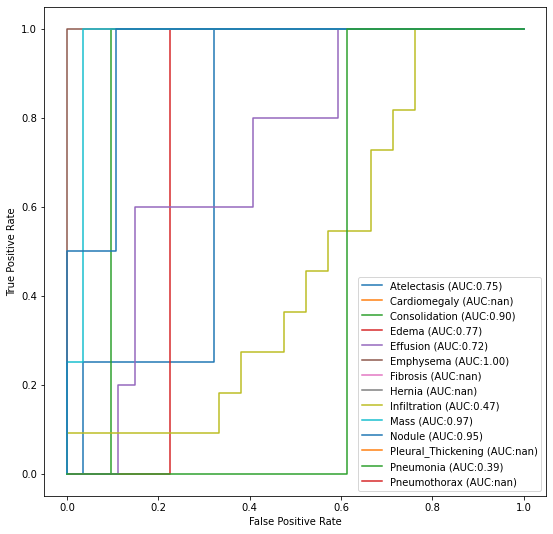

In [19]:
from sklearn.metrics import roc_curve, auc

avg = []

fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    avg.append(auc(fpr, tpr))
    
print(sum(avg) / len(avg))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [ ]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=50,
                                  validation_data = valid_gen, 
                                  validation_steps = 20,
                                  epochs = 50, 
                                  callbacks = callbacks_list)

Epoch 1/50
